In [43]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the saved model
saved_model_path = 'models/brain_mri_classifier-v0.keras'
model = tf.keras.models.load_model(saved_model_path)

/Users/jonathan/Documents/École/Paris 8/S1/Outils de programmation avancée pour l’IA/.tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Tryng inference 

In [44]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing import image

# Define the path to your model
model_path = 'models/brain_mri_classifier-v0.keras'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Define the class labels (update with your actual class labels)
class_labels = ["Healthy", "Tumor", "Alzheimer"]  # Modify as per your dataset

# Function to preprocess the image before feeding it to the model
def preprocess_image(img_path, img_height=512, img_width=512):
    img = image.load_img(img_path, target_size=(img_height, img_width))  # Load and resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image values (if needed)
    return img_array

# Function to perform inference on selected images
def infer_images(image_paths):
    for img_path in image_paths:
        if os.path.exists(img_path):  # Check if the file exists
            img_array = preprocess_image(img_path)  # Preprocess the image
            prediction = model.predict(img_array)  # Perform inference

            # Get the predicted class (max probability)
            predicted_class_idx = np.argmax(prediction, axis=-1)[0]
            predicted_class = class_labels[predicted_class_idx]
            print(f"Image: {img_path}")
            print(f"Predicted Class: {predicted_class} (Index: {predicted_class_idx})")
            print(f"Prediction probabilities: {prediction}\n")
        else:
            print(f"Image file {img_path} does not exist.\n")

# Example usage
image_paths = ['./data/alzheimer/alzheimer_brain_1.jpg', 
              './data/healthy/healthy_brain_1.jpg', 
              './data/tumor/tumor_brain_1.jpg']  

infer_images(image_paths)


## Providing explanability

In [45]:
!pip install -q lime


In [46]:
images = list()
for img_path in image_paths:
    if os.path.exists(img_path):  # Check if the file exists
        images.append(preprocess_image(img_path)) # Preprocess the image
        

100%|██████████| 1000/1000 [01:05<00:00, 15.31it/s]


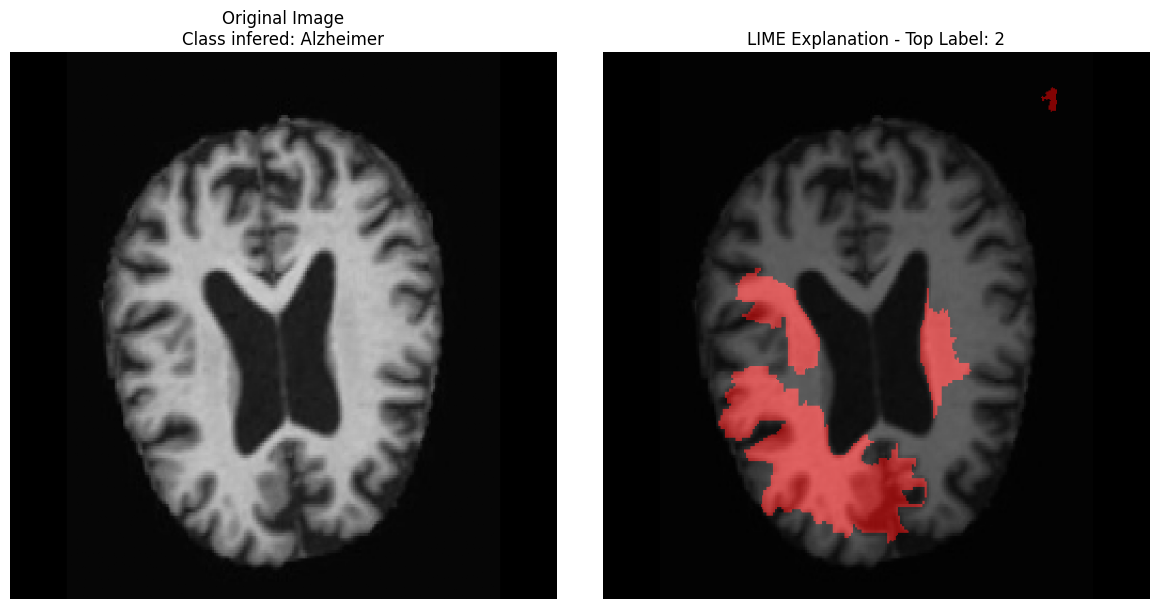

In [37]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

from tqdm import tqdm
import sys
import os

# Suppress tqdm output globally
sys.stdout = open(os.devnull, 'w')


# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define a function for predictions
def predict_fn(images):
    # Preprocess and predict with the model
    images = np.array(images, dtype="float32")
    return model.predict(images)

# Select an image for explanation
img = images[0]  # Assuming images is a list or array of images
img = img.astype('float32')  # Ensure the image is of type float32

# Remove the first dimension (batch size)
img = img.squeeze()  # This will change the shape from (1, 512, 512, 3) to (512, 512, 3)

# Check the image shape
print(f"Processed image shape: {img.shape}")

# Ensure the image has 3 channels (RGB)
if img.shape[-1] != 3:
    raise ValueError(f"Image does not have 3 color channels (RGB). Found {img.shape[-1]} channels.")

# Explain the prediction for the selected image
explanation = explainer.explain_instance(
    img,  # Input image
    predict_fn,  # Prediction function
    top_labels=10,  # Number of top labels to explain
    hide_color=0,  # Color for occluded regions
    num_samples=1000  # Number of perturbations to generate
)

# Get the explanation for the top class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=True,  # Show positive contributions only
    num_features=10,  # Number of superpixels to highlight
    hide_rest=False  # Show other regions in grayscale
)

# Normalize the image for overlay (if necessary)
img_norm = img / 255.0  # Normalize to [0, 1] if not already normalized

# Superimpose the explanation mask on the original image
overlay = label2rgb(mask, image=img, bg_label=0, alpha=0.5)

# Extracting true image label
prediction = model.predict(images[0])  # Perform inference
# Get the predicted class (max probability)
predicted_class_idx = np.argmax(prediction, axis=-1)[0]
predicted_class = class_labels[predicted_class_idx]

# Display the original and explained images side by side
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original Image\nClass infered: {predicted_class}")
plt.axis("off")

# Plot explanation overlay
plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"LIME Explanation - Top Label: {top_label}")
plt.axis("off")

plt.tight_layout()
plt.show()
# Restore stdout to normal
sys.stdout = sys.__stdout__


### Explanbility function

100%|██████████| 1000/1000 [01:05<00:00, 15.26it/s]


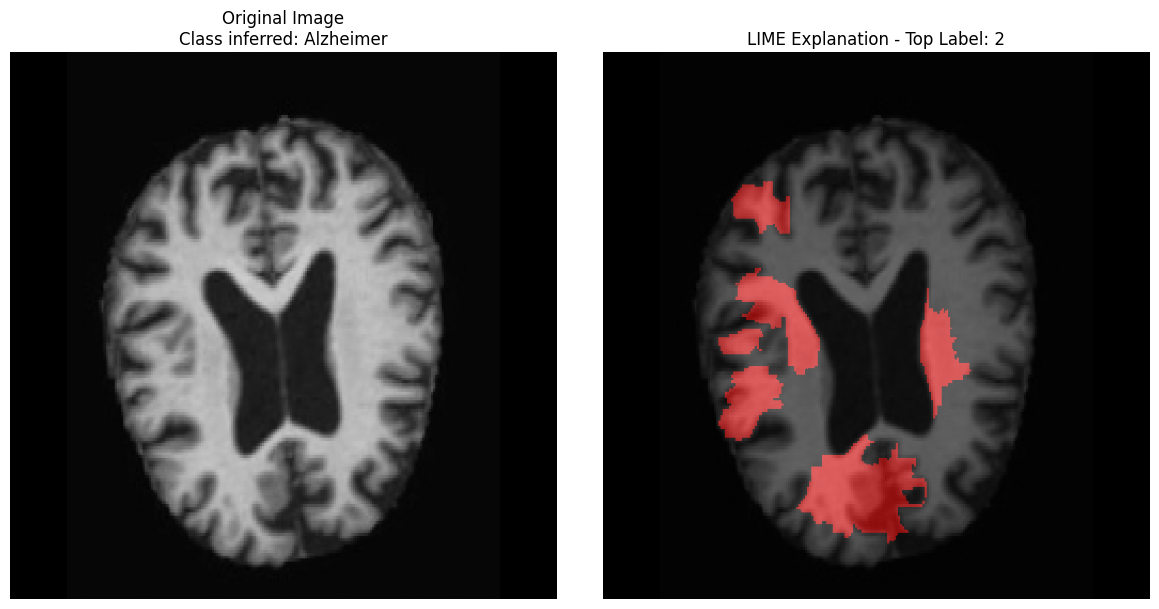

100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


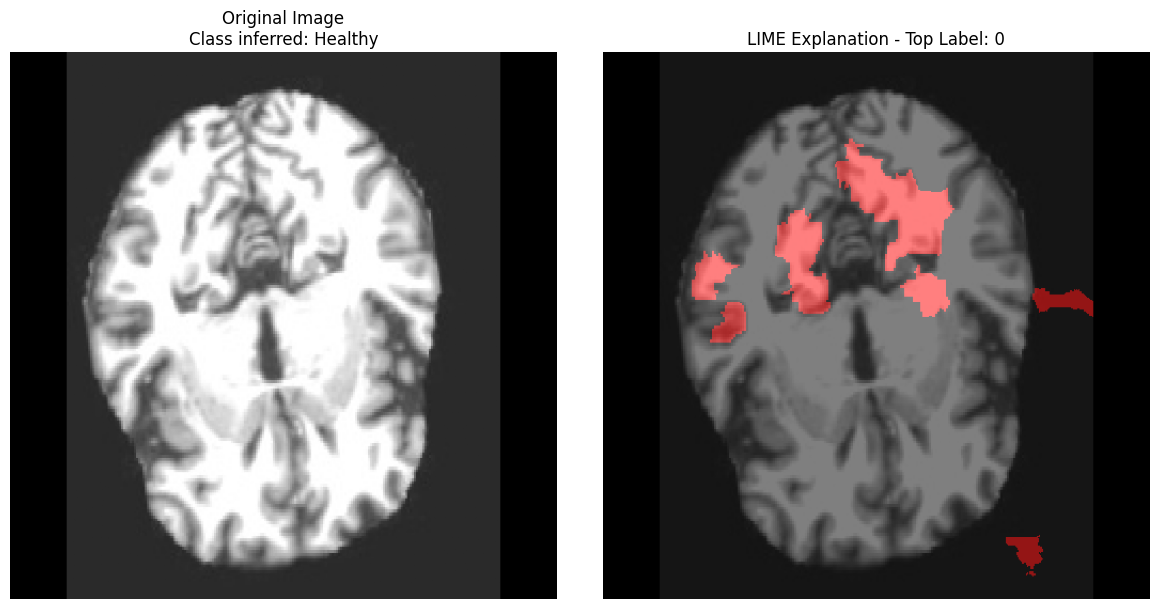

100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]


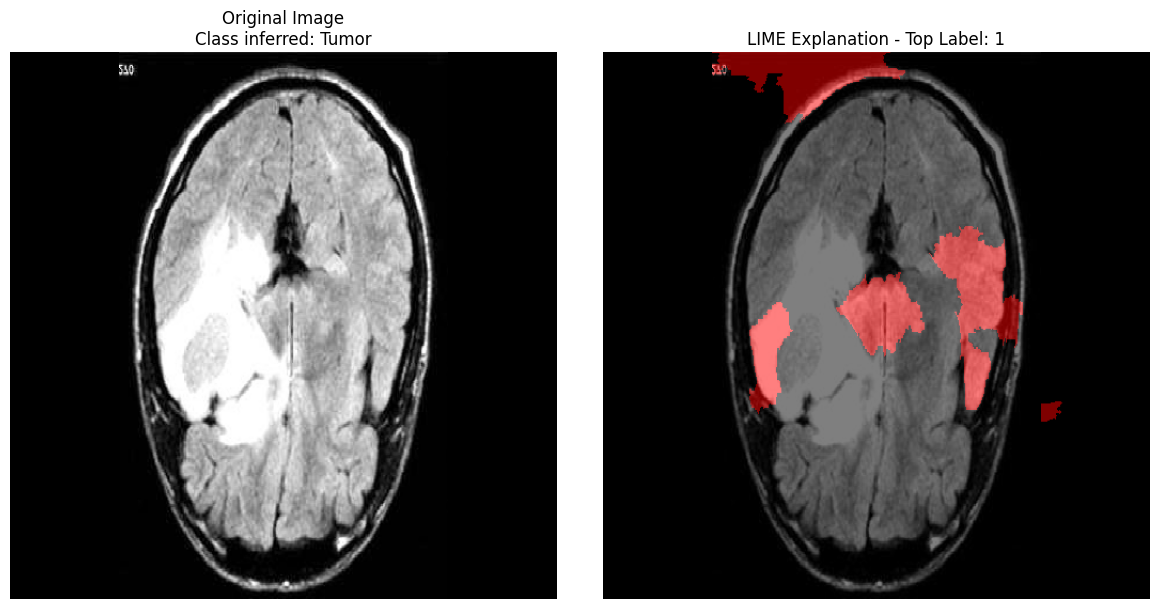

In [38]:
def explain_with_lime(image, model, class_labels, top_labels=5, num_samples=1000):
    # Suppress tqdm output globally
    sys.stdout = open(os.devnull, 'w')

    img = image.astype('float32')  # Ensure the image is of type float32
    img = img.squeeze()  # Remove batch dimension (if any)

    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Define prediction function
    def predict_fn(img):
        # Ensure the images are in the correct format (batch of images)
        img = np.array(img, dtype="float32")
        predictions = model.predict(img)
        
        # Ensure the output has the shape (num_samples, num_classes)
        return predictions

    # Explain the image
    explanation = explainer.explain_instance(
        img, predict_fn, top_labels=top_labels, hide_color=0, num_samples=num_samples
    )

    # Get the inferred label from the prediction
    # Extracting true image label
    # Perform inference & Get the predicted class (max probability)
    predicted_class_idx = np.argmax(model.predict(image) , axis=-1)[0]
    predicted_class = class_labels[predicted_class_idx]

    # Plot the original and explained images
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image\nClass inferred: {predicted_class}")
    plt.axis("off")

    # Plot explanation overlay
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    overlay = label2rgb(mask, image=img, bg_label=0, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"LIME Explanation - Top Label: {top_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Restore stdout to normal
    sys.stdout = sys.__stdout__


# Example usage
# 1. Loading images
images = list()
for img_path in image_paths:
    if os.path.exists(img_path):  # Check if the file exists
        images.append(preprocess_image(img_path)) # Preprocess the image
        
# 2. Explaining predictions
for image in images:
    explain_with_lime(image, model, class_labels)


In [10]:
!pip install -q shap


PartitionExplainer explainer: 2it [01:02, 62.81s/it]               


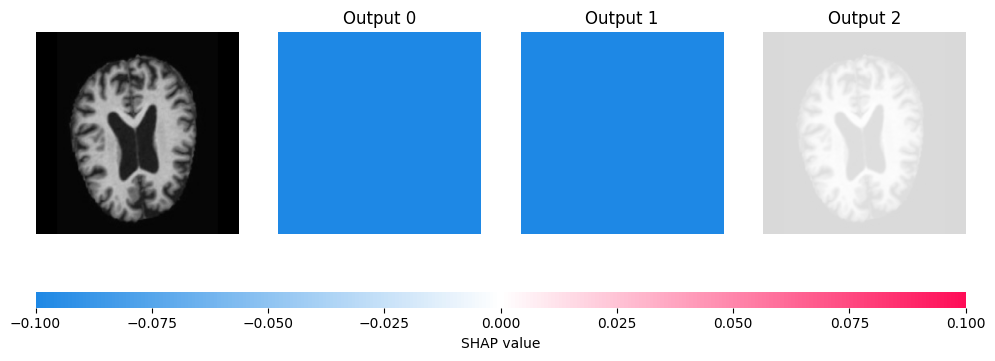

In [47]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from tqdm import tqdm
import sys
import os

# Suppress tqdm output globally
sys.stdout = open(os.devnull, 'w')

# Define a function for predictions
def predict_fn(images):
    # Preprocess and predict with the model
    images = np.array(images, dtype="float32")
    return model.predict(images)

# Create a SHAP explainer for images
explainer = shap.Explainer(predict_fn, masker=shap.maskers.Image("inpaint_telea", (512, 512, 3)))

# Select an image for explanation
image = images[0]  # Assuming img_array is preprocessed
shap_values = explainer(image)  # Explain the image

# Visualize the SHAP explanation
shap.image_plot(shap_values, image)


## Script logic

In [ ]:
# Modules, data and model import

# Inference and explainability of loaded images

/Users/jonathan/Documents/École/Paris 8/S1/Outils de programmation avancée pour l’IA/.tf_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jonathan/Documents/École/Paris 8/S1/Outils de programmation avancée pour l’IA/.tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
100%|██████████| 1000/1000 [01:02<00:00, 15.89it/s]


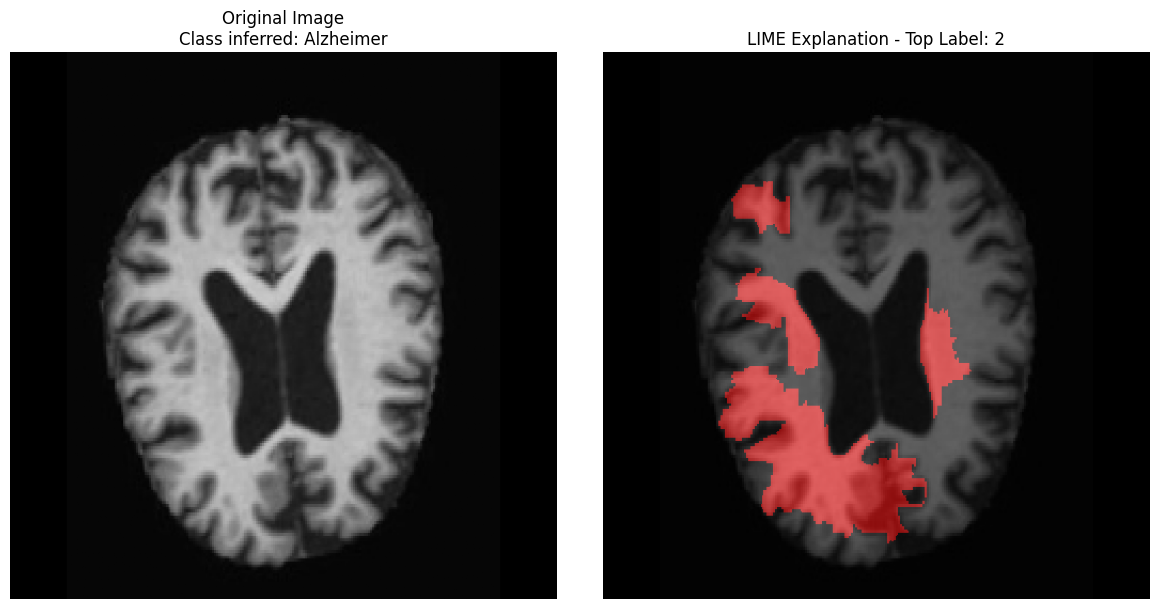

100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


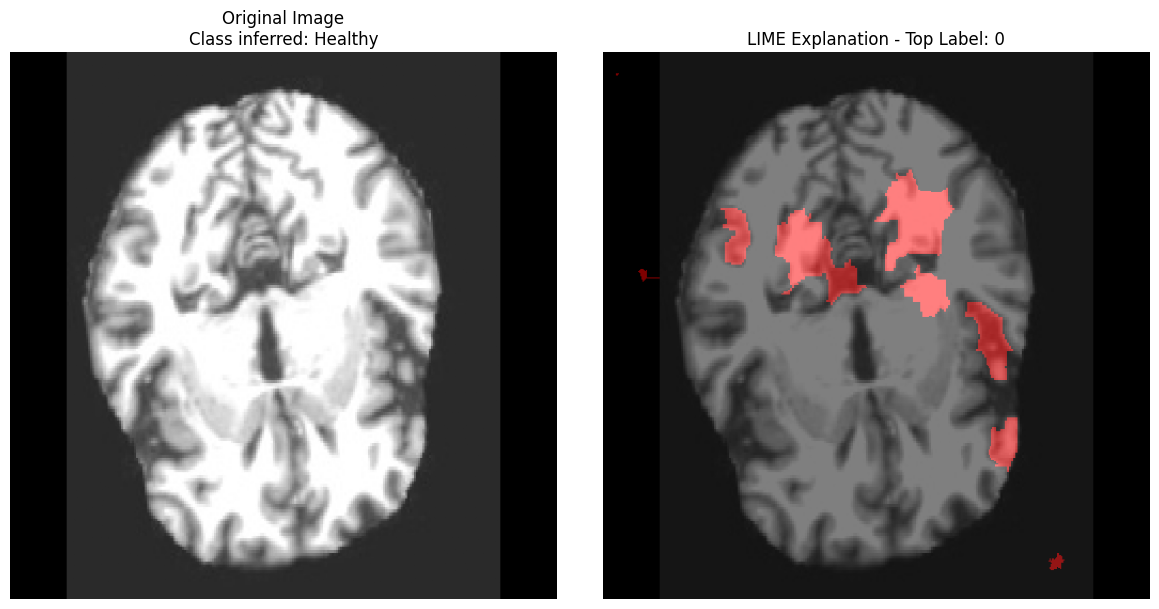

 21%|██        | 207/1000 [00:14<00:44, 17.83it/s]

In [1]:
# !pip install -q lime
import cv2
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from lime import lime_image
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
from tqdm import tqdm
import sys


# Suppress tqdm output globally
sys.stdout = open(os.devnull, 'w')

### Preprocessing and inference
# Function to preprocess the image before feeding it to the model
def preprocess_image(img_path, img_height=512, img_width=512):
    img = image.load_img(img_path, target_size=(img_height, img_width))  # Load and resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image values (if needed)
    return img_array

# Function to perform inference on selected images
def infer_images(image_paths):
    for img_path in image_paths:
        if os.path.exists(img_path):  # Check if the file exists
            img_array = preprocess_image(img_path)  # Preprocess the image
            prediction = model.predict(img_array)  # Perform inference

            # Get the predicted class (max probability)
            predicted_class_idx = np.argmax(prediction, axis=-1)[0]
            predicted_class = class_labels[predicted_class_idx]
            print(f"Image: {img_path}")
            print(f"Predicted Class: {predicted_class} (Index: {predicted_class_idx})")
            print(f"Prediction probabilities: {prediction}\n")
        else:
            print(f"Image file {img_path} does not exist.\n")



### EXPLAINABILITY

def explain_with_lime(image, model, class_labels, top_labels=5, num_samples=1000):
    # Suppress tqdm output globally
    sys.stdout = open(os.devnull, 'w')

    img = image.astype('float32')  # Ensure the image is of type float32
    img = img.squeeze()  # Remove batch dimension (if any)

    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Define prediction function
    def predict_fn(img):
        # Ensure the images are in the correct format (batch of images)
        img = np.array(img, dtype="float32")
        predictions = model.predict(img)
        
        # Ensure the output has the shape (num_samples, num_classes)
        return predictions

    # Explain the image
    explanation = explainer.explain_instance(
        img, predict_fn, top_labels=top_labels, hide_color=0, num_samples=num_samples
    )

    # Get the inferred label from the prediction
    # Extracting true image label
    # Perform inference & Get the predicted class (max probability)
    predicted_class_idx = np.argmax(model.predict(image) , axis=-1)[0]
    predicted_class = class_labels[predicted_class_idx]

    # Plot the original and explained images
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image\nClass inferred: {predicted_class}")
    plt.axis("off")

    # Plot explanation overlay
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    overlay = label2rgb(mask, image=img, bg_label=0, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"LIME Explanation - Top Label: {top_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Restore stdout to normal
    sys.stdout = sys.__stdout__


## ExampleS usage
# Define the path to your model
model_path = 'models/brain_mri_classifier-v0.keras'
# Load the trained model
model = tf.keras.models.load_model(model_path)
# Define the class labels 
class_labels = ["Healthy", "Tumor", "Alzheimer"]  


image_paths = ['./data/alzheimer/alzheimer_brain_1.jpg', 
              './data/healthy/healthy_brain_1.jpg', 
              './data/tumor/tumor_brain_1.jpg']  

infer_images(image_paths)


# 1. Loading images
images = list()
for img_path in image_paths:
    if os.path.exists(img_path):  # Check if the file exists
        images.append(preprocess_image(img_path)) # Preprocess the image
        
# 2. Explaining predictions
for image in images:
    explain_with_lime(image, model, class_labels)